Si vous utilisez Google Colab, exécutez d'abord la cellule ci-dessous. La cellule présume que le code du TP1 (le dossier prog) se trouve dans MyDrive/IFT780/TP1/. Si ce n'est pas le cas, changez le chemin pour le vôtre. 

In [ ]:
# à exécuter uniquement sur les serveurs de google colab
from google.colab import drive
drive.mount('/content/drive')
!cp -r drive/MyDrive/IFT780/TP1/prog/* .

# TP1: Classifieur linéaire, fonction de perte **Entropie croisée**

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
from utils.data_utils import display_images

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch, label_names 

def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean

    # Ajout du biais
    X_ = np.hstack([X_, np.ones((X.shape[0], 1))])
    
    return X_

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
batch data shape:  (200, 3073)
batch labels shape:  (200,)
CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


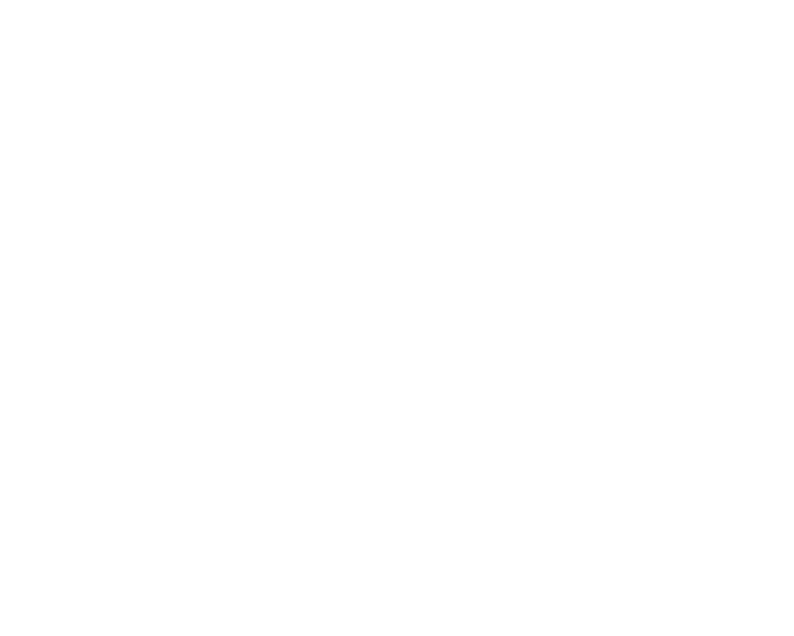

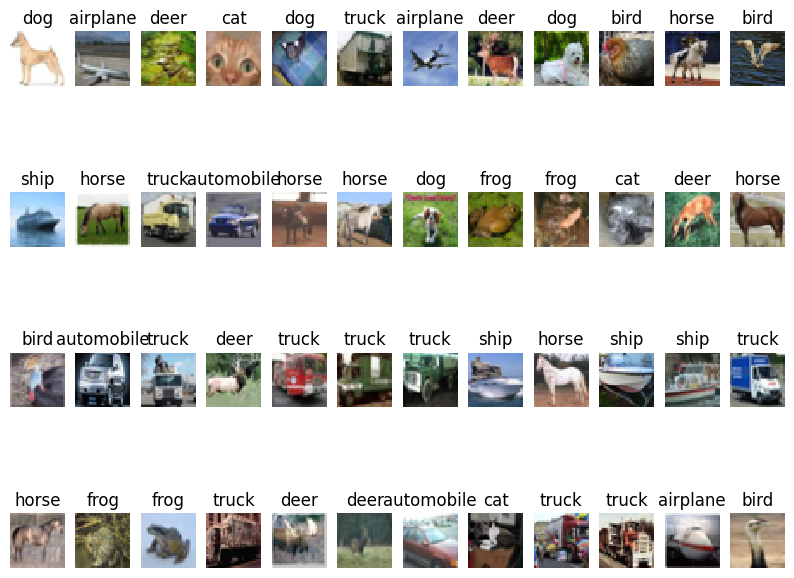

In [3]:
Data_train, y_train, Data_val, y_val, Data_test, y_test, Data_dev, y_dev, Data_batch, y_batch, label_names = get_CIFAR10_data()
X_train, X_val, X_test, X_dev, X_batch, = (preprocess_CIFAR10_data(Data) for Data in (Data_train, Data_val, Data_test, Data_dev, Data_batch))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)


    
print("CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes")
print(label_names)

display_images(Data_train, y_train, label_names)

## Question 1

Les prochaines étapes consistent à implanter le calcul de **l'entropie croisée** et de son **gradient**.   Vous commencerez avec une version naïve impliquant une boucle *for* sur l'ensemble des éléments d'une batch pour ensuite implanter une version vectorisée.   Mais avant de commencer à coder, veuillez donner ici la formule de l'entropie croisée et du gradient pour une mini-batch de 500 données contenue dans le tableau

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 


$$Loss = - \frac{1}{500} \sum ^{500} _{n=1}   ln \vec S_{t_n}  + 0.5 \lambda ||W||^2$$

avec $\vec S_{t_n}= \frac{e^{W_{t_n}^T \vec x + b_{t_n}}}{\sum ^{10} _{j=1} e^{W_j^T \vec x + b_j}}$

$$dW = (\vec S - \vec t) \vec x^{T} + \lambda W$$ 
avec $\vec S = [S_i]_{} $ où $ S_i = \frac{e^{W_i^T \vec x + b_i}]}{\sum ^{10} _{j=1} e^{W_j^T \vec x + b_j}}$

**NOTE IMPORTANT** : la réponse à cette question doit contenir un minimum de boucles (sommation), au bénéfice de multiplications matricielles et vectorielles.   Voir les notes de cours et https://info.usherbrooke.ca/pmjodoin/cours/ift603/softmax_grad.html pour vous aider...

## Classifieur linéaire SOFTMAX

Le code pour cette section est dans le fichier **utils/loss.py**. 

La fonction `softmax_ce_naive_forward_backward` estime la perte (et le gradient) à l'aide de boucles `for` qui itèrent sur chaque donnée de la mini-batch.  


Commençons par tester la **forward pass + l'entropie croisée**.  Pour l'instant, ignorons la rétro-propagation.

In [4]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_ce_naive_forward_backward située dans le fichier      #
#  utils.loss.                                                               #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 1 donnée à tester
np.random.seed(0)
W = np.random.randn(3073, 10) * 5e-4
X_rnd = np.random.randn(1, 3073) * 5
y_rnd = np.uint32(np.ones(1))
loss, _ = softmax_ce_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 2.276854
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)

Bravo!
loss error: 0.000000


In [5]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_ce_naive_forward_backward située dans le fichier      #
#  utils.loss.                                                               #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données 
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
loss, _ = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)

target_loss = 2.356459
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)


Bravo!
loss error: 0.000000


## Question 2:
Pourquoi s'attend-on que la loss soit approximativement -np.log(1/nb_classes))?

**Votre réponse:**
On a d'abord l'équation de la loss:

$$Loss = - \frac{1}{500} \sum ^{500} _{n=1}   ln \vec S_{t_n}$$

Si nous initialisons les poids de manières aléatoires, la sortie du réseau devrait être égal pour chaque classe. Comme la sortie du réseau est assimilable à une probabilité, elle doit sommer à 1. Ainsi nous obtenons l'équation suivante :
$$\sum _j S_{j} = 1$$ 
car toutes les sorties du réseau sont égales 

$$nb_{classes}\times S = 1$$
$$S = 1/nb_{classes}$$
Comme il y a autant de sorties que de nombre de classe, chaque sortie devrait être $\vec S_{t_n} = 1/nb_{classes}$. Ainsi, on a que

$$Loss = - \frac{1}{500} \sum ^{500} _{n=1}   ln (1/nb_{classes}) = -  \frac{500}{500}  ln (1/nb_{classes}) = -ln (1/nb_{classes})$$

In [6]:
###################################################################################
#  Vérification simple: s'assurer que l'entropie-croisée soit proche de           #
#  -log(1/nb_classes)                                                             #
###################################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données 
W = np.random.randn(3073, 10) * 1e-4
loss, _ = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)

# La loss d'un modèle non-entrainé devrait s'approcher de -log(0.1).
print('Softmax loss: %f' % loss)
print('Sanity check: %f' % (-np.log(0.1)))

Softmax loss: 2.339132
Sanity check: 2.302585


## Rétro-propagation

Maintenant, passons à la **rétro-propagation**!

In [7]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       softmax_ce_naive_forward_backward située dans le fichier utils.loss  #
#                                                                            #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + une donnée
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
X_rnd = np.random.randn(1, 3073)
y_rnd = np.uint32(np.ones(1))
loss, dW = softmax_ce_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 2.30114875
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-0.1279744 ,  1.15786877, -0.12847105])
dW_error = np.mean(np.abs(dW[0,0:3]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


In [8]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       softmax_ce_naive_forward_backward située dans le fichier utils.loss  #
#                                                                            #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
loss, dW = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)
print(dW[0,0:4])
# La loss suivante est celle que vous devriez obtenir
target_loss = 2.35680883
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-1.68817739, -1.37204569, -0.46158773, 1.9206649])
dW_error = np.mean(np.abs(dW[0,0:4]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

[-1.68817739 -1.37204569 -0.46158773  1.9206649 ]
Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


### Encore quelques vérifications d'usage
En principe, à ce point-ci, le calcul de l'entropie croisée (et de son gradient) via la fonction *softmax_ce_naive_forward_backward* devrait fonctionner.  Mais avant de passer à la prochaine étape il nous reste deux vérifications à faire : s'assurer que la **régularisation** fonctionne et passer le teste du **gradient numérique**

In [9]:
##############################################################################
# Vérifions que le fait d'augmenter le terme de régularisation L2            #
# augmente la loss...                                                        #
##############################################################################
success = True

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
prev_loss, _ = softmax_ce_naive_forward_backward(X_dev, W, y_dev, 0.0)

reg = 1e2
for i in range(10):
    loss, _ = softmax_ce_naive_forward_backward(X_dev, W, y_dev, reg)
    print(loss)
    if loss <= prev_loss:
        success = False
    prev_loss = loss
    reg *= 1.2
    
if success:
    print("Bravo!")
else:
    print('Erreur!')


2.402915004058999
2.4059830089111127
2.4096646147336496
2.4140825417206933
2.419384054105146
2.4257458689664895
2.4333800468001012
2.4425410602004356
2.4535342762808368
2.4667261355773182
Bravo!


In [16]:
##############################################################################
# Maintenant testons le gradient numérique avec et sans régularisation       #
# Les erreurs relatives devraient être inférieures à 1e-6                    #
##############################################################################
from utils.gradients import check_gradient_sparse

print("\n------------\nGradient check : reg=0\n------------\n")
check_gradient_sparse(softmax_ce_naive_forward_backward, W, X_dev, y_dev, 0.0)

# Faire un autre test de gradients avec régularisation 
print("\n------------\nGradient check : reg=1e-2\n------------\n")
check_gradient_sparse(softmax_ce_naive_forward_backward, W, X_dev, y_dev, 1e2)


------------
Gradient check : reg=0
------------

numerical: -1.270359, analytic -1.270359, relative error: 1.068514e-10
numerical: -0.263792, analytic -0.263792, relative error: 1.688973e-09
numerical: -1.218800, analytic -1.218800, relative error: 1.087704e-09
numerical: 0.938787, analytic 0.938787, relative error: 9.137374e-11
numerical: 1.956410, analytic 1.956410, relative error: 1.914632e-10
numerical: -0.048003, analytic -0.048003, relative error: 1.308401e-08
numerical: 0.819719, analytic 0.819719, relative error: 2.058769e-10
numerical: -5.741660, analytic -5.741660, relative error: 6.866659e-11
numerical: 0.113896, analytic 0.113896, relative error: 2.449846e-09
numerical: 0.818214, analytic 0.818214, relative error: 3.971781e-10

------------
Gradient check : reg=1e-2
------------

numerical: 2.231872, analytic 2.231872, relative error: 2.320065e-10
numerical: 1.178942, analytic 1.178942, relative error: 2.249852e-10
numerical: 2.403531, analytic 2.403531, relative error: 4

## Softmax et gradients vectorisés
Passons maintenant aux choses sérieuses. Vous devez ici coder la version vectorisée de l'entropie croisée et du gradient dans la fonction **softmax_ce_forward_backward**.  Ce code s'apparente à la réponse que vous avec donné au début.

In [11]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
# dans la fonction softmax_ce_forward_backward située dans le fichier        #
# utils.loss.                                                                #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être BEAUCOUP PLUS RAPIDE.                             #
##############################################################################
start = time.time()
loss_naive, grad_naive = softmax_ce_naive_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, end - start))

from utils.loss import softmax_ce_forward_backward
start = time.time()
loss_vectorized, grad_vectorized = softmax_ce_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, end - start))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
loss_diff = np.abs(loss_naive - loss_vectorized)
if loss_diff < 1e-7:
    print('bravo pour la loss!')
else:
    print('il y a un bug au niveau de la loss')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))

if grad_difference < 1e-7:
    print('bravo pour le gradient !')
else:
    print('il y a un bug au niveau du gradient')
print('Gradient difference: %f' % grad_difference)

naive loss: 2.387575e+00 computed in 4.855546s
vectorized loss: 2.387575e+00 computed in 0.002002s
bravo pour la loss!
Loss difference: 0.000000
bravo pour le gradient !
Gradient difference: 0.000000


## Entraînement
À l'aide de la classe **LinearClassifier** ainsi que de la fonction vectorisée **softmax_ce_forward_backward** que vous venez de coder, vous devez maintenant entraîner un réseau de neurones multiclasses linéaire à l'aide d'une **descente de gradient**.

Iterations : 3000 / 3000

train vs val acc 0.279429 / 0.292000


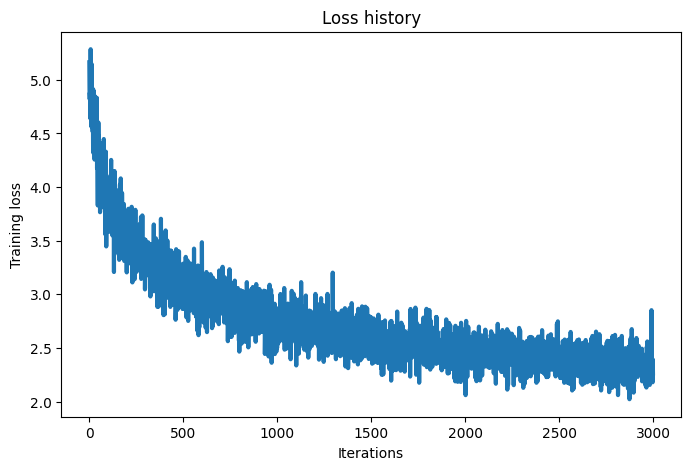

In [12]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
lr = 1e-7
reg = 1

classifier = LinearClassifier(softmax_ce_forward_backward)
#
# TODO : ajouter code à la fonction train.  Si tout fonctionne bien, la courbe de la loss devrait décroitre
#
train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=3000, verbose = True)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

acc_train = np.mean(y_train == y_train_pred)
acc_val = np.mean(y_val == y_val_pred)

print('train vs val acc %f / %f' %(acc_train, acc_val))

visualize_loss(train_loss_history)

## Recherche d'hyper-paramètres

d:\Téléchargements HDD 1\Devoir_1_aity1101_amat0601_arsp2802\utils\loss.py:94: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(np.log(S[:,y].diagonal())) / N + 0.5*reg*np.linalg.norm(W)**2
d:\Téléchargements HDD 1\Devoir_1_aity1101_amat0601_arsp2802\utils\loss.py:91: RuntimeWarning: invalid value encountered in divide
  S /= S.sum(axis=1, keepdims=True)


best validation accuracy achieved during cross-validation: 0.402000


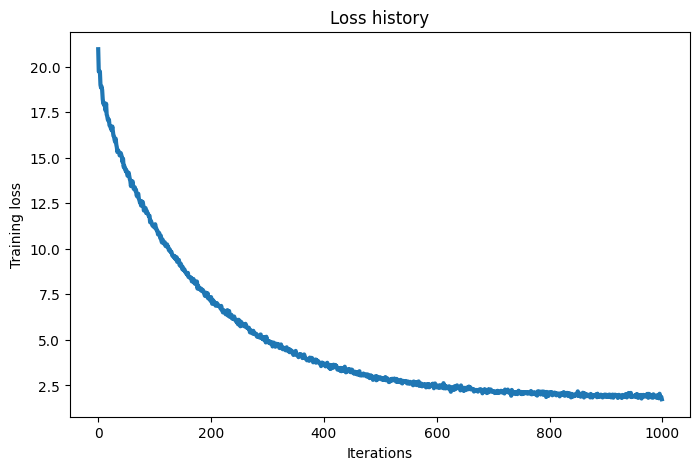

In [13]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
results = {}
best_val = -1
best_softmax = None # for what ?
learning_rates = np.linspace(1e-7, 1e-5, 5)
regularization_strengths = np.linspace(1e3, 1e7, 5)
best_loss_history = None
best_classifier = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (force de régularisation et vitesse d'apprentissage). Vous devez          #
#  expérimenter différentes plages de valeurs pour les taux d'apprentissage  #
#  et les forces de régularisation; si tout va bien, avec num_iter = 1000    #
#  vous devriez obtenir une précision de classification supérieur à 0.38 sur #
#  l'ensemble de validation, et de 0.37 sur l'ensemble de test.              #
#  Mettre les résultats des meilleurs hyper-paramètres dans les variables    #
#  best_XYZ ci haut.                                                         #
##############################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        cls = LinearClassifier(softmax_ce_forward_backward)
        loss = cls.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=1000)
        YPred = cls.predict(X_val)
        accVal = np.mean(y_val == YPred)
        results[accVal] = cls, loss

best_val = max(results.keys())
best_classifier, best_loss_history = results[best_val]

################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

visualize_loss(best_loss_history)

In [14]:
# On évalue le modèle sur l'ensemble de test
y_test_pred = best_classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Test set accuracy: %f' % (test_accuracy) )

Test set accuracy: 0.393000


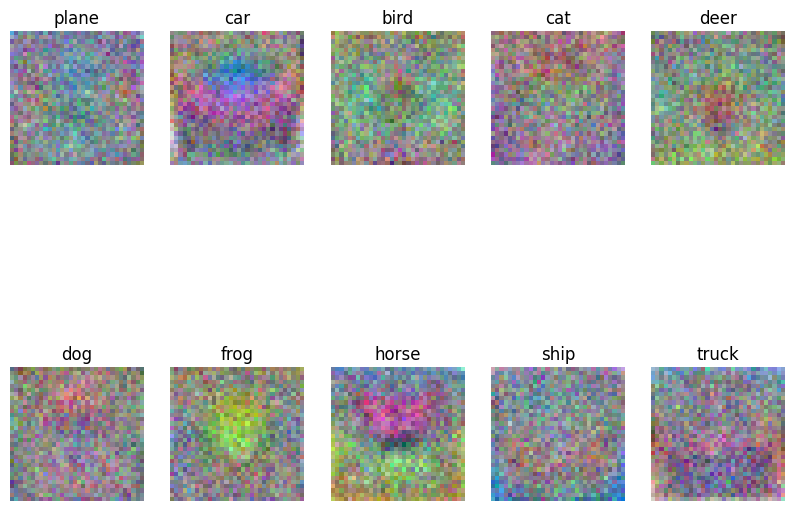

In [15]:
# Visualisation des poids appris pour chaque classe
w = best_classifier.W[:-1,:] # retire le biais
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Redimensionne les poids pour qu'ils soient entre 0 et 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])